# BTC as a Diversifier to US Equity

This exercise will explore the potential diversification benefits of Bitcoin to an all-US equity portfolio. This will be done by examing two core metrics: correlation and sharpe ratio. 

Correlation is compared during market sell-off periods as well as normal market periods. The purpose for this comparison is to find out if Bitcoin is a good diversifier to US equities when it's needed the most, which is when market sells off.  

For sharpe ratio, we compare sharpe ratio amongst BTC, SP500, NASDAQ, equally portfolios of BTC-SP500 and BTC-NASDAQ. The result of sharpe ratio will help determine the diversification benefit of BTC to equity.

In [49]:
# Initial imports
import pandas as pd
from dotenv import load_dotenv
import numpy as np
import datetime
import yfinance as yf
import hvplot.pandas
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb
import panel as pn
#import tabulate

In [50]:
load_dotenv()

True

# Data Exploration and Cleanup

For data download, we use Yahoo API for price history.  Only necessary columns were kept and NA were droped.

For data manipulation, a +/-2 standard deviation for SP500 daily price return was calculated.  

A sell off market environment is defined as any daily price returns all each asset that fall below the -2 standard deviation of SP500 daily price return.  

A normal market environment is defined as any daily price returns all each asset that fall within the -2 standard deviation and +2 standard deviation of SP500 daily price return.

Data is filtered with sell off and normal market conditions

In [51]:
# Download data from Yahoo API and clean data
today = datetime.date.today().isoformat()

response_yf = yf.download(
    "^GSPC ^IXIC BTC-USD", 
    start="2014-09-17", 
    end=today
)

# trimming the data
price_df = response_yf['Close']
price_df = price_df.rename(
    columns={
        '^GSPC': 'SP500', 
        '^IXIC': 'NASDAQ',
        'BTC-USD': 'BTC'
    }
).copy(deep=True)

# remove all NA 
price_df = price_df.dropna()

[*********************100%***********************]  3 of 3 completed


In [52]:
# Calculate daily price return for all assets.  Calculate the 2 standard deviation boundary for SP500

# calc daily percentage returns
pct_change_df = price_df.pct_change()
pct_change_df = pct_change_df.dropna()

pct_change_std = pct_change_df['SP500'].std()
pct_change_ret = pct_change_df['SP500'].mean()

# SP500 price return at 2 standard dev boundary
outlier_neg2std = pct_change_ret - pct_change_std * 2
outlier_pos2std = pct_change_ret + pct_change_std * 2

# Extract returns where S&P returns are greater 2 std dev
pct_change_outside_2std = pct_change_df.loc[
    pct_change_df['SP500'] <= outlier_neg2std
]
# Extract returns where S&P returns are within the 2 std dev
pct_change_inside_2std = pct_change_df.loc[
    (pct_change_df['SP500'] >= outlier_neg2std) & 
    (pct_change_df['SP500'] <= outlier_pos2std)
]

# Create a portfolio between BTC & SP500, NASDAQ
combined_pct_change = pd.concat(
    [
        pct_change_df['BTC'] + pct_change_df['SP500'],
        pct_change_df['BTC'] + pct_change_df['NASDAQ']
    ],
    axis=1
)

# Extract returns where S&P returns are greater 2 std dev
combined_pct_change_outside_2std = combined_pct_change.loc[
    pct_change_df['SP500'] <= outlier_neg2std
]

# Extract returns where S&P returns are within the 2 std dev
combined_pct_change_inside_2std = combined_pct_change.loc[
    (pct_change_df['SP500'] >= outlier_neg2std) & 
    (pct_change_df['SP500'] <=outlier_pos2std)
]

combined_pct_change.columns = ['BTC-SP500','BTC-NASDAQ']
combined_pct_change_outside_2std.columns = ['BTC-SP500','BTC-NASDAQ']
combined_pct_change_inside_2std.columns = ['BTC-SP500','BTC-NASDAQ']

In [53]:
# Verify that portfolio returns are added correctly
pct_change_df['BTC'].iloc[0]+pct_change_df['SP500'].iloc[0]

-0.06703439592607463

In [54]:
combined_pct_change['BTC-SP500'].iloc[0] 

-0.06703439592607463

# Correlation Analysis

In this section we'll examine the correlation between BTC vs. SP500 and NASDAQ in two different market environments. Correlation in the sell off market and normal market environment.

In [55]:
# Calculate correlation amongst all assets for returns that beyond the 2 std dev and within 2 std dev

# Correlation matrix
corr_outside_2std = pct_change_outside_2std.corr()
corr_inside_2std = pct_change_within.corr()

# Extract corr off the diagonal of the matrix
corr_2std = np.extract(1 - np.eye(len(corr_outside_2std)), corr_outside_2std)
corr_within  = np.extract(1 - np.eye(len(corr_outside_2std)), corr_inside_2std)

# Retrieve only correlation btween BTC vs equity and SP500 vs NASDAQ
ix=[0,1,3]
corr_2std = [corr_2std[i] for i in ix]
corr_within = [corr_within[i] for i in ix]

## Charting Section

#### Charting functions

In [56]:
def create_dist_chart_fill_opt(data, xloc1, xloc2, annotate_txt):
    
    # xloc1 or xloc2 is the number on x-axis where the chart is shaded beyond that location
    # if both xloc1 and xloc2 are provided then a shaded area is in between those 2 numbers.
    # if both xloc1 and xloc2 are empty then no shading is done
    
    plt.figure()
    ax = sb.distplot(data)
    x, y = ax.get_lines()[0].get_data()
    line = ax.lines[0].get_data()

    if bool(xloc1) & bool(xloc2):
        plt.vlines(xloc1, 0, y[np.argmin(abs(x-xloc1))], color='k')
        plt.vlines(xloc2, 0, y[np.argmin(abs(x-xloc2))], color='k')
        ax.fill_between(line[0], np.zeros(len(line[0])), line[1])
        ax.fill_between(
            x, y, 
            where=(x>xloc1) & (x<xloc2), 
            interpolate=True,
            color='#EF9A9A'
        )      

    elif bool(xloc1) | bool(xloc2):
        plt.vlines(xloc1, 0, y[np.argmin(abs(x-xloc1))], color='k')
        ax.fill_between(line[0], np.zeros(len(line[0])), line[1])
        ax.fill_between(
            x, y, 
            where=(x < xloc1), 
            interpolate=True, 
            color='#EF9A9A'
        )

    else:    
        ax = sb.distplot(data)
        ax.fill_between(line[0], np.zeros(len(line[0])), line[1])  
        
    ax.set_title('Distribution of SP500 Daily Price Return')   
    ax.text(-0.12, 10,annotate_txt, fontsize=9)  

In [57]:
def create_bar_chart(data,title):
    barplot = data.hvplot.bar(title=title,height=300,width=500)
    return barplot

### Chart density distribution charts
These charts highlighted the section of the data distribution that will be used to calculate the correlation for sell off and normal market periods.
We highlighted the +/- 2 standard deviation of SP500 price return on the charts.  The data used for the correlation analysis is highlighted by shaded area of the charts. 

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



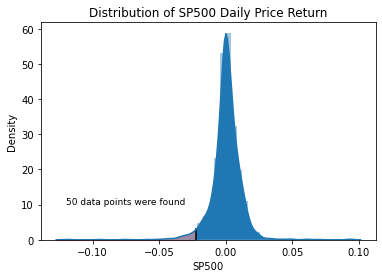

In [58]:
annotext = str(len(pct_change_outside_2std)) + " data points were found"

selloff_dist_chart = create_dist_chart_fill_opt(
    pct_change_df['SP500'],
    outlier_neg2std,
    [],
    annotext
)

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



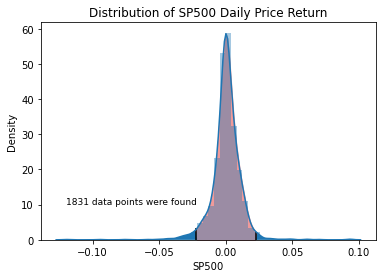

In [59]:
annotext = str(len(pct_change_within)) + " data points were found"

normal_dist_chart = create_dist_chart_fill_opt(
    pct_change_df['SP500'],
    outlier_neg2std,
    outlier_pos2std,
    annotext
)

### Correlation results
The distinct difference between correlations in during sell off market vs. normal market appears to suggest BTC is not a good diversifier to equity.  Equity needs diversification the most when market sells off.  The correlation between BTC and equity spiked ~ 5x during sell off market.  Correlation between SP500 and NASDAQ both remained high in both sell off and normal market environment.

In [60]:
corr_btc_equity = pd.concat(
    [
        pd.DataFrame(corr_2std),
        pd.DataFrame(corr_within)
    ], 
    axis=1
)

corr_btc_equity = corr_btc_equity.set_index([
    pd.Index([
        'BTC vs SP500',
        'BTC vs NASDAQ',
        'SP500 vs NASDAQ'
    ])
])

corr_btc_equity.columns = ['selloff','normal']
corr_btc_equity

,selloff,normal
BTC vs SP500,0.526344,0.087877
BTC vs NASDAQ,0.490430,0.118869
SP500 vs NASDAQ,0.932749,0.911174


In [61]:
selloff_chart = create_bar_chart(
    corr_btc_equity['selloff'],
    'Correlation between BTC vs SP500 and NASDAQ \nduring Sell Off Market'
)

selloff_chart

:Bars   [index]   (selloff)

In [62]:
normal_chart = create_bar_chart(
    corr_btc_equity['normal'],
    'Correlation between BTC vs SP500 and NASDAQ \nduring Normal Market'
)

normal_chart

:Bars   [index]   (normal)

In [63]:
corr_chart = pn.Column(selloff_chart + normal_chart)
corr_chart

Column
    [0] HoloViews(Layout)

# Return and Risk Analysis 
In this analysis we'd like to examine the risk and return profile of each asset and an equally weighted portfolios of BTC-SP500 and BTC-NASDAQ.
The first section of the analysis, we examined the return and the max loss of the assets and portfolios.  We do this by looking at the recent 4 years of return data.  And we use sunburst chart to display the return vs. the max loss for all the assets and portfolios.
The second section of the analysis, we used an alternative metric of Sharpe ratio to assess the return for every unit of risk of each assets and portfolios.  We used hvplot to display our results.

In [64]:
# Manipulate the time series data into data that can be used for sunburst chart

# concatenate the BTC, SP, NASD returns with equally wgted portfolios
all_assets = pd.concat([pct_change_df, combined_pct_change], axis=1)
years = [2019, 2020, 2021, 2022]
data_sunburst = pd.DataFrame()
years_sunburst = pd.DataFrame()

# Loop through the last 4 years
for i in years:
    
    # Calculate the avg ret and min ret for each year
    yearly_data = all_assets[all_assets.index.year == i]
    yearly_avg = yearly_data.mean()
    yearly_min = yearly_data.min()
    year_df = pd.DataFrame([i] * len(all_assets.columns))   
    data_avg_min = pd.concat([yearly_avg, yearly_min], axis=1)
    data_sunburst = data_sunburst.append(data_avg_min)
    
    # Append each yearly data
    years_sunburst = years_sunburst.append(year_df)
    
data_sunburst.columns = ['avgret', 'minret']
data_sunburst['port'] = data_sunburst.index
data_sunburst = data_sunburst.reset_index(drop=True)
years_sunburst = years_sunburst.reset_index(drop=True) 
years_sunburst.columns=['year']
data_sunburst = pd.concat([data_sunburst,years_sunburst], axis=1)

In [65]:
# Create sunburst chart
retmxloss_chart = px.sunburst(
    data_sunburst, 
    path=['year', 'port'], 
    values='avgret',
    color='minret', 
    color_continuous_scale='RdBu',
    hover_data=['minret'],
)

retmxloss_chart.show()

### Sharpe results
Sharpe for BTC and the equally weighted outperformed both SP500 and NASDAQ.
Dispite high volatility of BTC and the portfolios, their return compensated for every unit of risk superior to SP500 and NASDAQ

In [66]:
# annualized return, risk and sharpe for individual assets for whole history
all_pct_change = pd.concat([pct_change_df, combined_pct_change], axis=1)
ann_ret = all_pct_change.mean() * 252
ann_std = all_pct_change.std() * np.sqrt(252)
ann_sharpe = ann_ret / ann_std

In [67]:
# Create bar chart to disply the annualized sharpe ratios
sharpe_bar_chart = create_bar_chart(ann_sharpe,'Annualized Sharpe Ratio for each assets and portfolios')
sharpe_bar_chart

:Bars   [index]   (0)

In [69]:
tabs = pn.Tabs(
    ("BTC - Equity Diversifier", sharpe_bar_chart),
    ("Returns vs. Max Loss", retmxloss_chart),
    ("Correlation in diff Markets",corr_chart),
    ("Return distribution", pn.Row(selloff_dist_chart,normal_dist_chart)))
tabs

Tabs
    [0] HoloViews(Bars, name='BTC - Equity D...)
    [1] Plotly(Figure, name='Returns vs. Max Loss')
    [2] Column
        [0] HoloViews(Layout)
    [3] Row
        [0] Str(None)
        [1] Str(None)